### The weighted majority

In [ ]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

To implement the weighted majority vote based on class probabilities

In [ ]:
ex = np.array([[0.9, 0.1],
    [0.8, 0.2],
    [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
np.argmax(p)

### Class Majority Claassifier

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self, classifiers, vote='classlabel', weights=None):
    self.classifiers = classifiers
    self.named_classifiers = {
        key: value for key,
        value in _name_estimators(classifiers)
        }
    self.vote = vote
    self.weights = weights

  def fit(self, X, y):
    if self.vote not in ('probability', 'classlabel'):
      raise ValueError(f"vote must be 'probability' "
      f"or 'classlabel'"
      f"; got (vote={self.vote})")
    if self.weights and len(self.weights) != len(self.classifiers):
      raise ValueError(f'Number of classifiers and'
        f' weights must be equal'
        f'; got {len(self.weights)} weights,'
        f' {len(self.classifiers)} classifiers')
    self.lablenc_ = LabelEncoder()
    self.lablenc_.fit(y)
    self.classes_ = self.lablenc_.classes_
    self.classifiers_ = []
    for clf in self.classifiers:
      fitted_clf = clone(clf).fit(X,self.lablenc_.transform(y))
      self.classifiers_.append(fitted_clf)
    return self

  def predict(self, X):
    if self.vote == 'probability':
      maj_vote = np.argmax(self.predict_proba(X), axis=1)
    else: # 'classlabel' vote
      # Collect results from clf.predict calls
      predictions = np.asarray([
        clf.predict(X) for clf in self.classifiers_
      ]).T
      maj_vote = np.apply_along_axis(
      lambda x: np.argmax(
      np.bincount(x, weights=self.weights)
      ),
      axis=1, arr=predictions
      )
    maj_vote = self.lablenc_.inverse_transform(maj_vote)
    return maj_vote

  def predict_proba(self, X):
    probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
    avg_proba = np.average(probas, axis=0,weights=self.weights)
    return avg_proba

  def get_params(self, deep=True):
    if not deep:
      return super().get_params(deep=False)
    else:
      out = self.named_classifiers.copy()
      for name, step in self.named_classifiers.items():
        for key, value in step.get_params(deep=True).items():
          out[f'{name}__{key}'] = value
      return out

### Using the majority voting principle to make predictions

Now it is time to put the MajorityVoteClassifier that we implemented in the previous section
into action. But rst, let’s prepare a dataset that we can test it on. Since we are already familiar with
techniques to load datasets from CSV les, we will take a shortcut and load the Iris dataset from
scikit-learn’s datasets module. Furthermore, we will only select two features, sepal width and pet-
al length, to make the classication task more challenging for illustration purposes. Although our
MajorityVoteClassifier generalizes to multiclass problems, we will only classify ower examples
from the Iris-versicolor and Iris-virginica classes, with which we will compute the ROC AUC
later. The code is as follows:

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

Next, we will split the Iris examples into 50 percent training and 50 percent test data:

In [ ]:
X_train, X_test, y_train, y_test =\
train_test_split(X, y,
test_size=0.5,
random_state=1,
stratify=y)

Using the training dataset, we now will train three different classiffers:
 - Logistic regression classiffer
 - Decision tree classiffer
 - k-nearest neighbors classiffer

We will then evaluate the model performance of each classier via 10-fold cross-validation on the
training dataset before we combine them into an ensemble classier:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

In [ ]:
clf1 = LogisticRegression(penalty='l2',
    C=0.001,
    solver='lbfgs',
    random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
    criterion='entropy',
    random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
    p=2,
    metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
    ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
    ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
    f'(+/- {scores.std():.2f}) [{label}]')


You may be wondering why we trained the logistic regression and k-nearest neighbors classier as
part of a pipeline. The reason behind it is that, as discussed in Chapter 3, both the logistic regression
and k-nearest neighbors algorithms (using the Euclidean distance metric) are not scale-invariant, in
contrast to decision trees. Although the Iris features are all measured on the same scale (cm), it is a
good habit to work with standardized features

Now, let’s move on to the more exciting part and combine the individual classiers for majority rule
voting in our MajorityVoteClassifier:

In [ ]:
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
    )
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
    X=X_train,
    y=y_train,
    cv=10,
    scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
    f'(+/- {scores.std():.2f}) [{label}]')

As you can see, the performance of MajorityVotingClassifier has improved over the individual
classiers in the 10-fold cross-validation evaluation.

### Evaluating and tuning the ensemble classifier

In this section, we are going to compute the ROC curves from the test dataset to check that
MajorityVoteClassifier generalizes well with unseen data. We must remember that the test data-
set is not to be used for model selection; its purpose is merely to report an unbiased estimate of the
generalization performance of a classiffier system:

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
    y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
    y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
    color=clr,
    linestyle=ls,
    label=f'{label} (auc = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
    linestyle='--',
    color='gray',
    linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

As you can see in the resulting ROC, the ensemble classier also performs well on the test dataset
(ROC AUC = 0.95

Before we tune the individual classier’s parameters for ensemble classication, let’s call the get_
params method to get a basic idea of how we can access the individual parameters inside a GridSearchCV
object:

In [ ]:
mv_clf.get_params()

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf,
param_grid=params,
cv=10,
scoring='roc_auc')
grid.fit(X_train, y_train)

In [ ]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
  mean_score = grid.cv_results_['mean_test_score'][r]
  std_dev = grid.cv_results_['std_test_score'][r]
  params = grid.cv_results_['params'][r]
  print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

In [ ]:
print(f'Best parameters: {grid.best_params_}')

In [ ]:
print(f'ROC AUC : {grid.best_score_:.2f}')

## Bagging

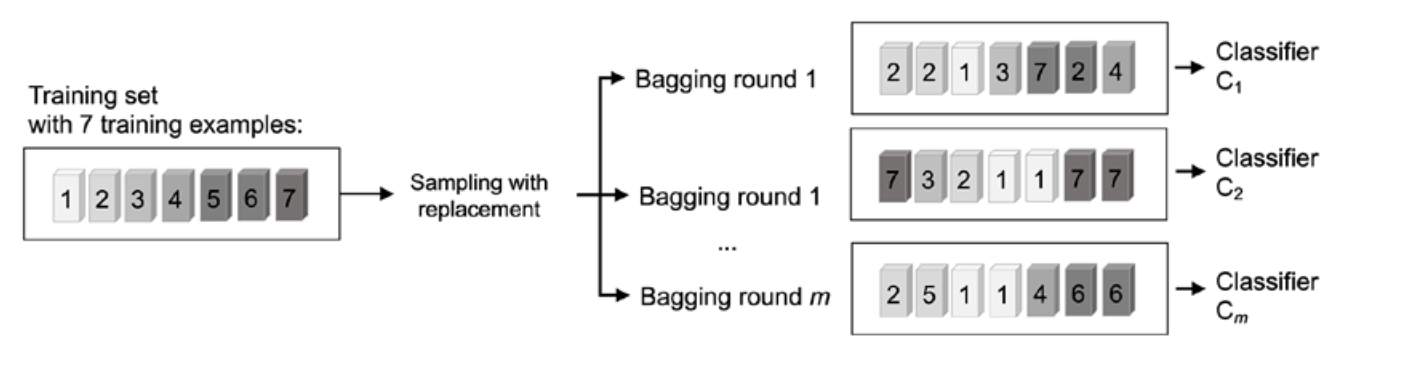

each classier receives a random subset of examples from the training
dataset. We denote these random samples obtained via bagging as Bagging round 1, Bagging round 2,
and so on. Each subset contains a certain portion of duplicates and some of the original examples don’t
appear in a resampled dataset at all due to sampling with replacement. Once the individual classiers
are t to the bootstrap samples, the predictions are combined using majority voting.

### Applying bagging to classify examples in the Wine dataset

To see bagging in action, let’s create a more complex classication problem using the Wine dataset
that was introduced in Chapter 4, Building Good Training Datasets – Data Preprocessing. Here, we will
only consider the Wine classes 2 and 3, and we will select two features – Alcohol and OD280/OD315
of diluted wines:

In [ ]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
  'machine-learning-databases/'
  'wine/wine.data',
  header=None)
df_wine.columns = ['Class label', 'Alcohol',
  'Malic acid', 'Ash',
  'Alcalinity of ash',
  'Magnesium', 'Total phenols',
  'Flavanoids', 'Nonflavanoid phenols',
  'Proanthocyanins',
  'Color intensity', 'Hue',
  'OD280/OD315 of diluted wines',
  'Proline']
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =\
  train_test_split(X, y,
  test_size=0.2,
  random_state=1,
  stratify=y)

A BaggingClassifier algorithm is already implemented in scikit-learn, which we can import from the
ensemble submodule. Here, we will use an unpruned decision tree as the base classier and create an
ensemble of 500 decision trees t on dierent bootstrap samples of the training dataset:

In [ ]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',
    random_state=1,
    max_depth=None)
bag = BaggingClassifier(estimator=tree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1)

Next, we will calculate the accuracy score of the prediction on the training and test datasets to com-
pare the performance of the bagging classier to the performance of a single unpruned decision tree:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
f'{tree_train:.3f}/{tree_test:.3f}')

Based on the accuracy values that we printed here, the unpruned decision tree predicts all the class
labels of the training examples correctly; however, the substantially lower test accuracy indicates high
variance (overtting) of the model:

In [ ]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging train/test accuracies '
f'{bag_train:.3f}/{bag_test:.3f}')

### Applying AdaBoost using scikit-learn

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
    random_state=1,
    max_depth=1)
ada = AdaBoostClassifier(estimator=tree,
    n_estimators=500,
    learning_rate=0.1,
    random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
    f'{tree_train:.3f}/{tree_test:.3f}')

### Gradient boosting training an ensemble based on loss gradients

In [ ]:
#!pip install -q XGBoost==1.5.0

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01,
max_depth=4, random_state=1,
use_label_encoder=False)
gbm = model.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)
gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost train/test accuracies '
f'{gbm_train:.3f}/{gbm_test:.3f}')

Here, we t the gradient boosting classier with 1,000 trees (rounds) and a learning rate of 0.01. Typi-
cally, a learning rate between 0.01 and 0.1 is recommended. However, remember that the learning rate
is used for scaling the predictions from the individual rounds. So, intuitively, the lower the learning
rate, the more estimators are required to achieve accurate predictions.

Next, we have the max_depth for the individual decision trees, which we set to 4. Since we are still
boosting weak learners, a value between 2 and 6 is reasonable, but larger values may also work well
depending on the dataset.
Finally, use_label_encoder=False disables a warning message which informs users that XGBoost is
not converting labels by default anymore, and it expects users to provide labels in an integer format
starting with label 0. (There is nothing to worry about here, since we have been following this format
throughout this book.)
There are many more settings available, and a detailed discussion is out of the scope of this book.
However, interested readers can nd more details in the original documentation at https://xgboost.
readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier

### Summary

we looked at some of the most popular and widely used techniques for ensemble
learning. Ensemble methods combine dierent classication models to cancel out their individual
weaknesses, which oen results in stable and well-performing models that are very attractive for
industrial applications as well as machine learning competitions.
At the beginning of this chapter, we implemented MajorityVoteClassifier in Python, which allows
us to combine dierent algorithms for classication. We then looked at bagging, a useful technique
for reducing the variance of a model by drawing random bootstrap samples from the training dataset
and combining the individually trained classiers via majority vote. Lastly, we learned about boosting
in the form of AdaBoost and gradient boosting, which are algorithms based on training weak learners
that subsequently learn from mistakes.
Throughout the previous chapters, we learned a lot about dierent learning algorithms, tuning, and
evaluation techniques. In the next chapter, we will look at a particular application of machine learn-
ing, sentiment analysis, which has become an interesting topic in the internet and social media era